In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup
### Data

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train, y_train, x_valid, y_valid = get_mnist_data()

In [5]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [6]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super(Model, self).__init__()
    self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
  def __call__(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [7]:
model = Model(m, nh, 10)

In [8]:
pred = model(x_train)

## Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:
$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$
or more concisely:
$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$
In practice, we will need the log of the softmax when we calculate the loss.

In [9]:
def log_softmax(x):
  return (x.exp() / (x.exp().sum(dim=-1, keepdim=True))).log()

In [10]:
sm_pred = log_softmax(pred)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:
$$ -\sum x\, \log p(x) $$
But since our $x$s are 1-hot encoded, this can be rewritten as $-\log (p_i)$ where $i$ is the index of the desired target.  
This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred[[0, 1, 2], [5, 0, 4]]

tensor([-2.3593, -2.3027, -2.3972], grad_fn=<IndexBackward>)

In [13]:
y_train.shape

torch.Size([50000])

In [14]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

In [15]:
loss = nll(sm_pred, y_train)

In [16]:
loss

tensor(2.3080, grad_fn=<NegBackward>)

Note that the formula:
$$\log \left( \frac{a}{b} \right) = \log(a) - \log(b)$$
gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [17]:
def log_softmax(x):
  return x - x.exp().sum(dim=-1, keepdim=True).log()

In [18]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:  
$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$  
where a is the maximum of the $x_{j}$.

In [19]:
def logsumexp(x):
  m = x.max(dim=-1)[0]
  return m + (x - m[:, None]).exp().sum(dim=-1).log()

In [20]:
test_near(logsumexp(pred), pred.logsumexp(dim=-1))

So we can use it for our `log_softmax` function.

In [21]:
def log_softmax(x):
  return x - x.logsumexp(dim=-1, keepdim=True)

In [22]:
test_near(nll(log_softmax(pred), y_train), loss)

The use PyTorch's implementation

In [23]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [24]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [25]:
loss_func = F.cross_entropy

In [26]:
#export
def accuracy(out, yb):
  return (torch.argmax(out, dim=1) == yb).float().mean()

In [27]:
bs = 64                # batch size

xb = x_train[:bs]      # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([ 0.0798, -0.1299,  0.0407,  0.0071, -0.0701, -0.0224, -0.1017, -0.1241,
          0.3799,  0.1656], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [28]:
yb = y_train[:bs]
loss_func(preds, yb)

tensor(2.3155, grad_fn=<NllLossBackward>)

In [29]:
accuracy(preds, yb)

tensor(0.1094)

In [30]:
lr = 0.5    # learning-rate
epochs = 1  # number of epochs

In [31]:
for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    x_batch = x_train[start_i: end_i]
    y_batch = y_train[start_i: end_i]
    loss = loss_func(model(x_batch), y_batch)
    loss.backward()
    
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad * lr
          l.bias -= l.bias.grad * lr
          l.weight.grad.zero_()
          l.bias.grad.zero_()

In [32]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1569, grad_fn=<NllLossBackward>), tensor(0.9531))

## Using parameters and optim
### Parameters
Use `nn.Module.__setattr__` and move relu to functional.

In [33]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super(Model, self).__init__()
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
    
  def __call__(self, x):
    out = self.l1(x)
    out = F.relu(out)
    out = self.l2(out)
    return out

In [34]:
model = Model(m, nh, 10)
for name, l in model.named_children():
  print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [35]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [36]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [37]:
def fit():
  for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
      start_i = i * bs
      end_i = start_i + bs
      x_batch = x_train[start_i: end_i]
      y_batch = y_train[start_i: end_i]
      loss = loss_func(model(x_batch), y_batch)
      loss.backward()

      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * lr
        model.zero_grad()

In [38]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1356, grad_fn=<NllLossBackward>), tensor(0.9531))

Behind the scene, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [39]:
class DummyModule():
  def __init__(self, n_in, nh, n_out):
    self._modules = {}
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
    
  def __setattr__(self, k, v):
    super().__setattr__(k, v)
    if not k.startswith('_'):
      self._modules[k] = v
      
  def __repr__(self):
    return f'{self._modules}'
  
  def parameters(self):
    for l in self._modules.values():
      for p in l.parameters():
        yield p

In [40]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [41]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules
We can use the original `layers` approach, but we have to register the modules.

In [42]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [43]:
class Model(nn.Module):
  def __init__(self, layers):
    super(Model, self).__init__()
    self.layers = layers
    for i, l in enumerate(self.layers):
      self.add_module(f'layer_{i}', l)
      
  def __call__(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [44]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList
`nn.ModuleList` does this for us

In [45]:
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    
  def __call__(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [46]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [47]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1415, grad_fn=<NllLossBackward>), tensor(0.9531))

### nn.Sequential
`nn.Sequential` is a convenient class which does the same as above

In [48]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [49]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1734, grad_fn=<NllLossBackward>), tensor(0.9531))

In [50]:
nn.Sequential??

Init signature: nn.Sequential(*args:Any)
Source:        
class Sequential(Module):
    r"""A sequential container.
    Modules will be added to it in the order they are passed in the constructor.
    Alternatively, an ordered dict of modules can also be passed in.

    To make it easier to understand, here is a small example::

        # Example of using Sequential
        model = nn.Sequential(
                  nn.Conv2d(1,20,5),
                  nn.ReLU(),
                  nn.Conv2d(20,64,5),
                  nn.ReLU()
                )

        # Example of using Sequential with OrderedDict
        model = nn.Sequential(OrderedDict([
                  ('conv1', nn.Conv2d(1,20,5)),
                  ('relu1', nn.ReLU()),
                  ('conv2', nn.Conv2d(20,64,5)),
                  ('relu2', nn.ReLU())
                ]))
    """

    @overload
    def __init__(self, *args: Module) -> None:
        ...

    @overload
    def __init__(self, arg: 'OrderedDict[str, Module]') ->

### optim

Let's replace our previous manually coded optimization step:
```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```
and instead use just:
```python
opt.step()
opt.zero_grad()
```

In [51]:
class Optimizer():
  def __init__(self, params, lr=0.5):
    self.params, self.lr = list(params), lr
    
  def step(self):
    with torch.no_grad():
      for p in self.params:
        p -= p.grad * self.lr
        
  def zero_grad(self):
    for p in self.params:
      p.grad.data.zero_()

In [52]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
opt = Optimizer(model.parameters())

In [53]:
for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    x_batch = x_train[start_i: end_i]
    y_batch = y_train[start_i: end_i]
    loss = loss_func(model(x_batch), y_batch)
    loss.backward()

    opt.step()
    opt.zero_grad()

In [54]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1381, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing in a more flexible way!)

In [55]:
#export
from torch import optim

In [56]:
optim.SGD.step??

Signature: optim.SGD.step(self, closure=None)
Source:   
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not

In [57]:
def get_model():
  model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
  return model, optim.SGD(model.parameters(), lr=lr)

In [58]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.2908, grad_fn=<NllLossBackward>)

In [59]:
for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    x_batch = x_train[start_i: end_i]
    y_batch = y_train[start_i: end_i]
    loss = loss_func(model(x_batch), y_batch)
    loss.backward()

    opt.step()
    opt.zero_grad()

In [60]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1656, grad_fn=<NllLossBackward>), tensor(0.9375))

In [61]:
assert acc > 0.7

## Dataset and DataLoader
### Dataset

It's clunky to iterate through minibatches of x and y values seperatedly.
```python
x_batch = x_train[start_i: end_i]
y_batch = y_train[start_i: end_i]
```
Instead, let's do these two steps together, by introducing a `Dataset` class.
```python
xb, yb = train_ds[i * bs, i * bs + bs]
```

In [62]:
#export
class Dataset():
  def __init__(self, x, y):
    self.x, self.y = x, y
    
  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [63]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [64]:
x_batch, y_batch = train_ds[:5]
assert x_batch.shape == (5, 28*28)
assert y_batch.shape == (5,)

In [65]:
x_batch, y_batch

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [66]:
model, opt = get_model()

In [67]:
for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    x_batch, y_batch = train_ds[i * bs: i * bs + bs]
    loss = loss_func(model(x_batch), y_batch)
    loss.backward()

    opt.step()
    opt.zero_grad()

In [68]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1462, grad_fn=<NllLossBackward>), tensor(0.9531))

### DataLoader
Previously, our loop iterated over batches (xb, yb) like this:
```python
for i in range((n - 1) // bs + 1):
    x_batch, y_batch = train_ds[i * bs: i * bs + bs]
    ...
```
Let's make our loop much cleaner, using a data loader:
```python
for xb, yb in train_dl:
    ...
```

In [69]:
class DataLoader():
  def __init__(self, ds, bs):
    self.ds, self.bs = ds, bs
    
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs):
      yield self.ds[i: i + self.bs]

In [70]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [71]:
x_batch, y_batch = next(iter(valid_dl))
assert x_batch.shape == (bs, 28 * 28)
assert y_batch.shape == (bs,)

tensor(3)

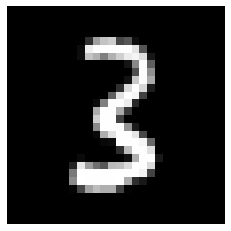

In [72]:
plt.imshow(x_batch[0].view(28, 28))
plt.axis('off')
y_batch[0]

In [73]:
model, opt = get_model()

In [74]:
def fit():
  for x_batch, y_batch in train_dl:
    loss = loss_func(model(x_batch), y_batch)
    loss.backward()
    
    opt.step()
    opt.zero_grad()

In [75]:
fit()

In [76]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1534, grad_fn=<NllLossBackward>), tensor(0.9375))

### Random sampling
We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [77]:
class Sampler():
  def __init__(self, ds, bs, shuffle=False):
    self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    
  def __iter__(self):
    self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
    for i in range(0, self.n, self.bs):
      yield self.idxs[i: i + self.bs]

In [78]:
small_ds = Dataset(*train_ds[:10])

In [79]:
s = Sampler(small_ds, 3, shuffle=False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [80]:
s = Sampler(small_ds, 3, shuffle=True)
[o for o in s]

[tensor([3, 5, 4]), tensor([1, 8, 0]), tensor([7, 9, 2]), tensor([6])]

In [81]:
def collate(b):
  xs, ys = zip(*b)
  return torch.stack(xs), torch.stack(ys)

class DataLoader():
  def __init__(self, ds, sampler, collate_fn=collate):
    self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    
  def __iter__(self):
    for s in self.sampler:
      yield self.collate_fn([self.ds[i] for i in s])
      # Simple implementation, need to test
      # yield self.ds[s]

In [82]:
for sampler in s:
  print(sampler)
  x1, y1 = collate([train_ds[i] for i in sampler])
  x2, y2 = train_ds[sampler]
  break

tensor([5, 8, 0])


In [83]:
assert all(y1 == y2)

In [84]:
test_near(x1, x2)

In [85]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [86]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

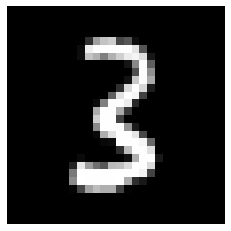

In [87]:
x_batch, y_batch = next(iter(valid_dl))
plt.imshow(x_batch[0].view(28, 28))
plt.axis('off')
y_batch[0]

tensor(2)

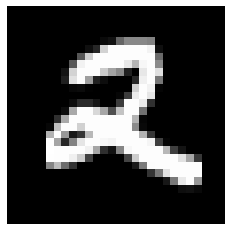

In [88]:
x_batch, y_batch = next(iter(train_dl))
plt.imshow(x_batch[0].view(28, 28))
plt.axis('off')
y_batch[0]

tensor(6)

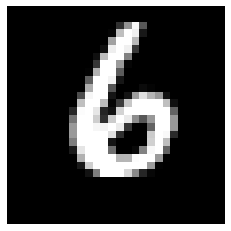

In [89]:
x_batch, y_batch = next(iter(train_dl))
plt.imshow(x_batch[0].view(28, 28))
plt.axis('off')
y_batch[0]

In [90]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.0887, grad_fn=<NllLossBackward>), tensor(0.9844))

### PyTorch DataLoader

In [91]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [92]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [93]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3491, grad_fn=<NllLossBackward>), tensor(0.8750))

PyTorch's defaults work fine for most things however

In [94]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [95]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1592, grad_fn=<NllLossBackward>), tensor(0.9688))

Note that PyTorch's `DataLoader`, if you pass `num_workders`, will use multiple threads to call your `Dataset`

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.  
We will calculate and print the validation loss at the end of each epoch.  
(Note that we always call `model.train()` before training and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [96]:
def fit(epochs, model, loss_func, opt, train_dl, valid_df):
  for epoch in range(epochs):
    model.train()
#     print(model.training)
    for x_batch, y_batch in train_dl:
      loss = loss_func(model(x_batch), y_batch)
      loss.backward()
      opt.step()
      opt.zero_grad()
      
    model.eval()
#     print(model.training)
  
    with torch.no_grad():
      total_loss, total_acc = 0.0, 0.0
      for x_batch, y_batch in valid_dl:
        preds = model(x_batch)
        total_loss += loss_func(preds, y_batch)
        total_acc += accuracy(preds, y_batch)
    nv = len(valid_dl)
    print(f'Epoch: {epoch}, Loss: {total_loss / nv}, Acc: {total_acc / nv}')
  return total_loss / nv, total_acc / nv

*Question*: Are these validation results correct if batch size varies?

`get_dls` returns dataloaders for training and validation sets:

In [97]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
  return DataLoader(train_ds, bs, shuffle=True, **kwargs), DataLoader(valid_ds, bs * 2, shuffle=False, **kwargs)

Now, our whole process of obtaining the data loaders and fittting the model can be run in 3 lines of code.

In [98]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

Epoch: 0, Loss: 0.17283466458320618, Acc: 0.9488726258277893
Epoch: 1, Loss: 0.13509704172611237, Acc: 0.9604430198669434
Epoch: 2, Loss: 0.22611337900161743, Acc: 0.921875
Epoch: 3, Loss: 0.1129840761423111, Acc: 0.9660798907279968
Epoch: 4, Loss: 0.09697632491588593, Acc: 0.972507894039154


In [99]:
assert acc > 0.9

## Export

In [100]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to nb_03.py
